<h1 style="
  background: linear-gradient(to right, #2c3e50, #3498db);
  color: white;
  padding: 25px;
  text-align: center;
  border-radius: 12px;
  font-size: 40px;
  letter-spacing: 1px;
  font-family: 'Segoe UI', 'Helvetica Neue', sans-serif;
">
📊 Suppression de la ligne de base dans les signaux 1D à l’aide d’un U-Net résiduel 📊
</h1>


Ce projet explore la suppression de baseline dans des signaux 1D synthétiques. On génère des signaux (composantes sinusoïdales + impulsions + bruit), on ajoute des dérives lentes (polynôme + sin basse fréquence), puis on compare des méthodes classiques (Savitzky–Golay, AsLS) à un ResUNet-1D supervisé. Évaluation via RMSE/MAE, corrélation et gain de SNR.

# 1. Introduction Générale

L’estimation et la correction de la ligne de base (baseline) dans les signaux sont des étapes fondamentales dans de nombreuses applications de mesure et de surveillance.
Lorsqu’un signal contient une composante de dérive lente — due par exemple à des effets de capteurs, de température ou de modélisation — cette tendance peut masquer l’information utile et conduire à des erreurs d’interprétation ou de mesure.
L’objectif d’une méthode de baseline removal est donc de séparer la composante utile (signal dynamique) de la composante lente (baseline), afin de restituer un signal corrigé et exploitable.

Dans la littérature, plusieurs méthodes ont été développées pour résoudre ce problème. Les approches classiques s’appuient sur des techniques de filtrage ou de lissage telles que le filtre de Savitzky–Golay, la régression polynomiale, ou encore le lissage pénalisé (Whittaker / AsLS).
Ces méthodes reposent sur des hypothèses explicites concernant la forme de la baseline (polynomiale, lisse, etc.) et sur des paramètres (fenêtre, ordre, facteur de régularisation) souvent choisis de manière empirique.

Cependant, dans de nombreux cas, la baseline ne suit pas une forme simple : elle peut être non linéaire, instationnaire, et dépendre d’interactions complexes entre plusieurs composantes du signal.
Dans ce contexte, les approches de Machine Learning et de Deep Learning offrent une alternative prometteuse : elles permettent d’apprendre directement la relation entre le signal d’entrée (contenant la baseline) et le signal cible (corrigé), sans imposer de forme analytique particulière.

Ce notebook s’inscrit dans cette démarche.
Il propose de générer un jeu de données synthétiques composé de signaux 1D (sinusoïdes, impulsions, bruit) auxquels sont ajoutées différentes formes de baseline (polynomiales, sinusoïdales lentes, etc.), puis d’évaluer différentes approches de suppression de baseline :

- Approches classiques : Savitzky–Golay, AsLS, régression polynomiale.

- Approches basées données : réseaux de neurones convolutionnels 1D, et plus particulièrement un ResUNet-1D.

L’objectif final est de comparer quantitativement et visuellement ces méthodes en termes d’erreur moyenne (RMSE, MAE), de corrélation et de gain de SNR, et d’illustrer la capacité du modèle profond à s’adapter à des cas variés de dérives.

# 2. Problématique et contexte du projet

## 2.1 Contexte

Dans de nombreux systèmes de mesure, les signaux captés ne reflètent pas uniquement le phénomène d’intérêt : ils contiennent également des composantes parasites lentes et de faible fréquence, que l’on appelle baselines.
Ces dérives peuvent provenir de plusieurs sources : imperfections de capteurs, effets thermiques, instabilités du système ou artefacts de traitement.

Une mauvaise estimation ou correction de cette baseline peut induire des erreurs significatives dans les mesures dérivées (amplitude, fréquence, phase, etc.), voire fausser totalement l’analyse.
La suppression automatique et robuste de cette composante constitue donc un enjeu majeur en traitement du signal.

Le but du projet est de concevoir, entraîner et évaluer des méthodes capables de corriger automatiquement la baseline d’un signal, sans connaissance préalable de sa forme.
Les signaux utilisés ici sont entièrement synthétiques, afin de permettre un contrôle précis de la forme et de l’amplitude de la dérive ainsi que du bruit ajouté.

## 2.2 Méthode proposée

Chaque signal généré est constitué d’une composante utile (oscillations, impulsions simulant des événements rapides) et d’une composante de dérive lente (baseline) additionnées à du bruit aléatoire.
La tâche du modèle est donc d’estimer le signal “corrigé” à partir du signal “brut”.

Le pipeline étudié comprend :

- une étape de génération de jeux de données synthétiques variés ;

- une évaluation comparative entre filtres classiques et réseaux de neurones ;

- un modèle ResUNet-1D entraîné de manière supervisée pour prédire la version corrigée du signal ;

- une visualisation et une application interactive Streamlit permettant d’expérimenter différentes méthodes de correction.

L’enjeu principal est de montrer qu’un modèle apprenant, correctement régularisé, peut capturer des formes de baseline complexes que les méthodes déterministes échouent à modéliser, tout en restant générique et interprétable.

# 3. Formulation mathématique du problème

La suppression de baseline peut être formulée comme un **problème d’estimation inverse**.  
On considère qu’un signal mesuré $s(t)$ résulte de la superposition de trois composantes principales :

$$
s(t) = x(t) + b(t) + \varepsilon(t)
$$

où :  
- $x(t)$ représente la **composante utile** du signal (information physique d’intérêt, oscillations, impulsions, etc.) ;  
- $b(t)$ désigne la **baseline** ou tendance lente, généralement lisse et de basse fréquence ;  
- $\varepsilon(t)$ est un **bruit aléatoire** centré, issu de perturbations instrumentales ou de modélisation.

L’objectif est d’estimer une version corrigée du signal, notée $\hat{x}(t)$, telle que :

$$
\hat{x}(t) \approx x(t)
\quad \text{et} \quad
s(t) - \hat{x}(t) \approx b(t)
$$

La qualité d’une méthode de correction de baseline se mesure par la **proximité** entre la sortie estimée $\hat{x}(t)$ et le signal cible $x(t)$, à l’aide de métriques d’erreur :

$$
\text{RMSE} = \sqrt{\frac{1}{N} \sum_{i=1}^{N} (x_i - \hat{x}_i)^2}
$$

$$
\text{MAE} = \frac{1}{N} \sum_{i=1}^{N} |x_i - \hat{x}_i|
$$

et de **métriques de similarité** telles que le **coefficient de corrélation de Pearson** :

$$
r = \frac{\sum_i (x_i - \bar{x})(\hat{x}_i - \bar{\hat{x}})}
{\sqrt{\sum_i (x_i - \bar{x})^2 \sum_i (\hat{x}_i - \bar{\hat{x}})^2}}
$$

Enfin, on peut définir un **gain en rapport signal/bruit (SNR)** avant et après correction :

$$
\Delta \text{SNR} =
10 \log_{10}\!\left(\frac{\mathrm{Var}(x)}{\mathrm{Var}(s - x)}\right)
-
10 \log_{10}\!\left(\frac{\mathrm{Var}(x)}{\mathrm{Var}(s - \hat{x})}\right)
$$

## 3.1 Approche déterministe (basée modèle)

Les méthodes classiques cherchent à approximer directement la baseline $b(t)$ à partir du signal $s(t)$ sous certaines hypothèses de régularité.  
On écrit alors :

$$
\hat{b}(t) = \arg\min_b \big( \|s(t) - b(t)\|^2 + \lambda \, R(b) \big)
$$

où :
- le premier terme contrôle la **fidélité** de la baseline estimée au signal original ;  
- le second terme $R(b)$ pénalise les variations rapides (favorise la lissité) ;  
- $\lambda > 0$ est un **paramètre de régularisation** équilibrant les deux effets.

Selon la forme choisie pour $R(b)$, on obtient différentes familles de méthodes :
- $R(b) = \|b''(t)\|^2$ → **Whittaker smoothing / AsLS** ;  
- $b(t)$ polynomiale d’ordre $p$ → **régression polynomiale** ;  
- Fenêtrage local + polynôme → **Savitzky–Golay**.

Ces méthodes sont simples, rapides et interprétables, mais nécessitent un **choix manuel des hyperparamètres** (taille de fenêtre, ordre, λ) et peuvent échouer lorsque la baseline n’est pas régulière ou présente des discontinuités locales.

## 3.2 Approche apprise (basée données)

L’approche d’apprentissage automatique repose sur la construction d’un modèle paramétré $f_\theta$, entraîné pour approximer directement la relation entre un signal d’entrée $s(t)$ et son équivalent corrigé $x(t)$ :

$$
\hat{x}(t) = f_\theta(s(t))
$$

Les paramètres $\theta$ du modèle (poids du réseau) sont ajustés par **apprentissage supervisé** sur un ensemble d’exemples synthétiques $(s_i, x_i)$ selon la fonction de coût :

$$
\mathcal{L}(\theta) =
\frac{1}{N} \sum_{i=1}^N \|x_i - f_\theta(s_i)\|^2
$$

Dans ce projet, le modèle choisi est un **ResUNet-1D** — une architecture convolutionnelle à connexions résiduelles et à structure en U, permettant de combiner :
- une **analyse multi-échelle** des composantes fréquentielles du signal,  
- et une **reconstruction précise** du signal corrigé, grâce aux connexions de saut (*skip connections*).

Cette architecture a pour avantage d’être **générique, différentiable et non paramétrique**, ce qui lui permet de s’adapter à des formes de baseline variées, tout en préservant les détails rapides du signal utile.

## 3.3 Objectif de comparaison

L’objectif final est de **comparer les performances** entre les méthodes déterministes et apprenantes selon les critères suivants :
- précision sur des signaux synthétiques variés (formes de baseline, bruit, impulsions) ;  
- stabilité visuelle des signaux corrigés ;  
- robustesse aux variations de fréquence et d’amplitude ;  
- complexité de mise en œuvre et capacité de généralisation.

# 4. Méthodologie et pipeline expérimental

Cette section décrit la méthodologie mise en œuvre pour la génération des données synthétiques, l’entraînement des modèles, et l’évaluation des performances de correction de baseline.

## 4.1 Génération de données synthétiques

Les données utilisées dans ce projet sont entièrement **générées artificiellement** afin de reproduire différents cas de signaux 1D présentant une dérive lente (*baseline*) et un bruit réaliste.

Chaque signal est défini comme la somme de trois composantes principales :

$$
s(t) = x(t) + b(t) + \varepsilon(t)
$$

où :

- $x(t)$ est la **composante utile** composée :
  - de sinusoïdes de fréquences moyennes,
  - d’impulsions aléatoires (gaussiennes étroites) simulant des événements rapides ;
- $b(t)$ est la **baseline lente**, modélisée par :
  - un polynôme d’ordre 2 ou 3,
  - une sinusoïde basse fréquence ;
- $\varepsilon(t)$ est un **bruit additif gaussien** centré de variance contrôlée.

Le jeu de données complet contient $N$ signaux de longueur $L$, notés $s_i(t)$ et $x_i(t) $, générés selon la procédure :

1. Création du signal utile :
   $$
   x_i(t) = \sum_k a_k \sin(2\pi f_k t + \phi_k)
   + \sum_j A_j \, e^{-\frac{(t - c_j)^2}{2\sigma_j^2}}
   $$
   où les amplitudes $a_k, A_j$, fréquences $f_k$, centres $c_j$ et largeurs $\sigma_j$ sont tirés aléatoirement.
2. Ajout de la baseline lente :
   $$
   b_i(t) = \alpha_0 + \alpha_1 t + \alpha_2 t^2 + \beta \sin(2\pi f_b t)
   $$
3. Ajout du bruit :
   $$
   \varepsilon_i(t) \sim \mathcal{N}(0, \sigma^2)
   $$
4. Signal final :
   $$
   s_i(t) = x_i(t) + b_i(t) + \varepsilon_i(t)
   $$

Les signaux sont ensuite normalisés de manière indépendante avant d’être utilisés pour l’apprentissage :

$$
s_i(t) \leftarrow \frac{s_i(t) - \mu_i}{\sigma_i}
\quad \text{avec} \quad
\mu_i = \text{moyenne}(s_i), \quad \sigma_i = \text{écart-type}(s_i)
$$

## 4.2 Méthodes évaluées

Trois approches principales sont comparées :

### Méthodes classiques (basées modèle)

1. **Savitzky–Golay**  
   Approximation polynomiale locale du signal et soustraction de la tendance estimée.

2. **AsLS / Whittaker smoothing**  
   Lissage pénalisé fondé sur la minimisation :
   $$
   \min_b \| s - b \|^2 + \lambda \| D^2 b \|^2
   $$
   où $D^2$ est l’opérateur de dérivation discrète d’ordre 2 et $\lambda$ le paramètre de régularisation.

3. **Régression polynomiale globale**  
   Ajustement d’un polynôme d’ordre $p$ à la baseline, suivi de la soustraction du signal corrigé.

### Méthode apprise (basée données)

Un **ResUNet-1D** est entraîné de manière supervisée à apprendre la transformation $ s(t) \rightarrow x(t) $.  
Ce modèle comprend :
- un **encodeur** de convolutions 1D successives avec sous-échantillonnage,
- un **goulot (bottleneck)** pour capter les dépendances globales,
- un **décodeur** symétrique avec *upsampling*,
- et des **connexions de saut** (*skip connections*) entre couches symétriques.

L’entraînement est réalisé en minimisant une fonction de perte de type **erreur absolue moyenne (MAE)** :

$$
\mathcal{L}(\theta) = \frac{1}{N} \sum_{i=1}^N \| x_i - f_\theta(s_i) \|_1
$$

Un petit taux d’apprentissage et un arrêt anticipé (*early stopping*) sont utilisés pour stabiliser la convergence.

## 4.3 Évaluation et métriques

Les performances sont mesurées sur un jeu de validation indépendant à l’aide de plusieurs indicateurs :

- **Erreur quadratique moyenne (RMSE)** :
  $$
  \text{RMSE} = \sqrt{\frac{1}{N}\sum_i (x_i - \hat{x}_i)^2}
  $$
- **Erreur absolue moyenne (MAE)** :
  $$
  \text{MAE} = \frac{1}{N}\sum_i |x_i - \hat{x}_i|
  $$
- **Corrélation de Pearson (r)** :
  $$
  r = \frac{\sum_i (x_i - \bar{x})(\hat{x}_i - \bar{\hat{x}})}
  {\sqrt{\sum_i (x_i - \bar{x})^2 \sum_i (\hat{x}_i - \bar{\hat{x}})^2}}
  $$
- **Gain de SNR** :
  $$
  \Delta \text{SNR} = 10 \log_{10}\!\left(\frac{\mathrm{Var}(x)}{\mathrm{Var}(s - \hat{x})}\right)
  - 10 \log_{10}\!\left(\frac{\mathrm{Var}(x)}{\mathrm{Var}(s - x)}\right)
  $$

Des visualisations comparatives (avant/après correction) sont également produites pour juger la **stabilité temporelle** et la **finesse du filtrage** des différentes approches.

## 4.4 Organisation du pipeline

Le pipeline expérimental complet peut être résumé comme suit :

1. **Génération des signaux synthétiques**
   - Création des couples $(s_i, x_i)$
2. **Prétraitement**
   - Normalisation, découpage et conversion en tenseurs PyTorch
3. **Entraînement**
   - Apprentissage supervisé du modèle ResUNet-1D
4. **Évaluation**
   - Calcul des métriques (RMSE, MAE, $r$, ΔSNR)
5. **Comparaison**
   - Résultats classiques vs ResUNet-1D
6. **Visualisation / Démo**
   - Application Streamlit interactive pour corriger un signal depuis un fichier CSV

## 4.5 Résumé

Ce protocole permet de comparer de manière cohérente différentes stratégies de suppression de baseline sur des signaux variés, tout en assurant la reproductibilité des expériences grâce à la génération synthétique et au contrôle des paramètres.

# Déroulé du code

## Imports et paramètres globaux

In [ ]:
# Imports principaux
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from scipy import sparse
from scipy.sparse.linalg import spsolve
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

# Paramètres généraux
plt.rcParams["figure.figsize"] = (10, 4)
plt.rcParams["axes.grid"] = True
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device utilisé :", device)


Device utilisé : cpu


## Génération de signaux synthétiques

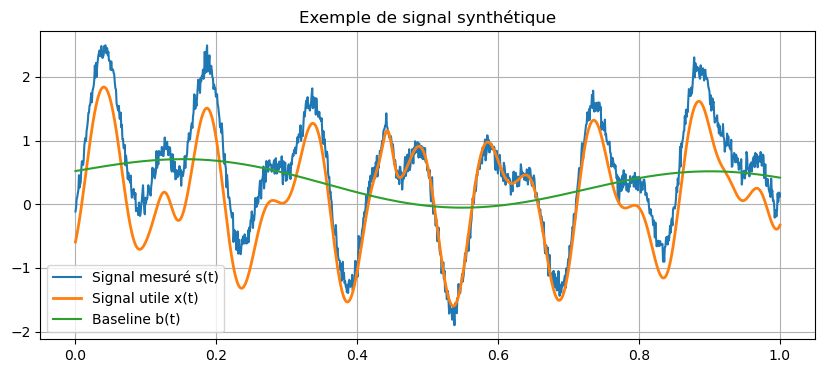

In [3]:
def generate_signal(L=1600, seed=None):
    rng = np.random.default_rng(seed)
    t = np.linspace(0, 1, L)

    # composante utile : sinusoïdes + impulsions
    signal = (
        1.0 * np.sin(2 * np.pi * 7 * t)
        + 0.6 * np.sin(2 * np.pi * 13 * t + rng.uniform(0, 2 * np.pi))
    )
    for _ in range(rng.integers(3, 8)):
        c = rng.uniform(0, 1)
        w = rng.uniform(0.003, 0.02)
        a = rng.uniform(0.3, 1.0)
        signal += a * np.exp(-0.5 * ((t - c) / w) ** 2)

    # baseline lente : polynôme + sin basse fréquence
    baseline = (
        rng.uniform(-0.5, 0.5)
        + rng.uniform(-1, 1) * (t - 0.5)
        + rng.uniform(-0.5, 0.5) * (t - 0.5) ** 2
        + 0.3 * np.sin(2 * np.pi * rng.uniform(0.5, 1.5) * t)
    )

    # bruit gaussien
    noise = rng.normal(0, 0.1, L)

    # signal final
    s = signal + baseline + noise
    return t, signal, baseline, s


# Exemple visuel
t, x, b, s = generate_signal(L=1200, seed=42)
plt.plot(t, s, label="Signal mesuré s(t)")
plt.plot(t, x, label="Signal utile x(t)", lw=2)
plt.plot(t, b, label="Baseline b(t)", lw=1.5)
plt.legend(), plt.title("Exemple de signal synthétique")
plt.show()


## Méthodes classiques de suppression de baseline

### Savitzky–Golay + soustraction

In [6]:
def remove_baseline_savgol(signal, win=101, poly=3):
    base = savgol_filter(signal, window_length=win, polyorder=poly, mode="interp")
    corrected = signal - base
    return corrected, base

### AsLS (Adaptive Smoothness)

In [7]:
def asls_baseline(y, lam=1e5, p=0.01, niter=10):
    L = len(y)
    D = sparse.diags([1, -2, 1], [0, -1, -2], shape=(L, L-2))
    w = np.ones(L)
    for i in range(niter):
        W = sparse.spdiags(w, 0, L, L)
        Z = W + lam * D.dot(D.transpose())
        z = spsolve(Z, w * y)
        w = p * (y > z) + (1 - p) * (y < z)
    return z

def remove_baseline_asls(signal, lam=1e5, p=0.01):
    base = asls_baseline(signal, lam=lam, p=p)
    corrected = signal - base
    return corrected, base


### Comparaison rapide

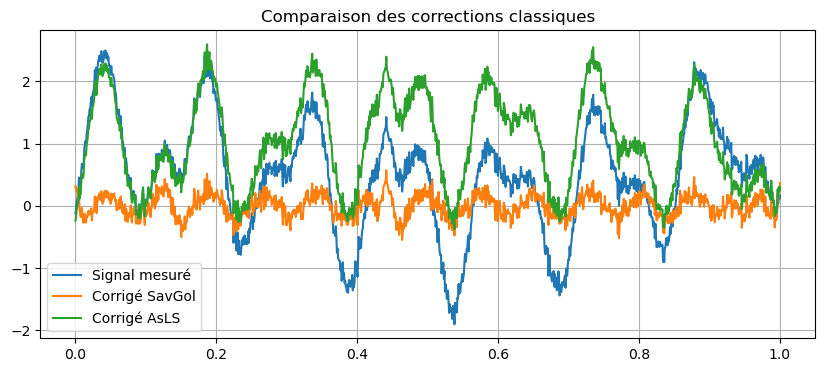

In [8]:
y_sg, b_sg = remove_baseline_savgol(s)
y_asls, b_asls = remove_baseline_asls(s)

plt.plot(t, s, label="Signal mesuré")
plt.plot(t, y_sg, label="Corrigé SavGol")
plt.plot(t, y_asls, label="Corrigé AsLS")
plt.legend(), plt.title("Comparaison des corrections classiques")
plt.show()


# Définition du modèle ResUNet-1D (simplifié)

In [12]:
import torch
import torch.nn as nn

class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, k=3):
        super().__init__()
        p = k // 2
        self.block = nn.Sequential(
            nn.Conv1d(in_ch, out_ch, k, padding=p),
            nn.BatchNorm1d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv1d(out_ch, out_ch, k, padding=p),
            nn.BatchNorm1d(out_ch),
            nn.ReLU(inplace=True),
        )
    def forward(self, x):
        return self.block(x)

class Down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.MaxPool1d(2),
            ConvBlock(in_ch, out_ch)
        )
    def forward(self, x):
        return self.net(x)

class Up(nn.Module):
    def __init__(self, in_ch, out_ch):
        """
        in_ch = canaux concaténés = ch(upsample) + ch(skip)
        out_ch = canaux après le bloc de conv
        """
        super().__init__()
        self.up = nn.Upsample(scale_factor=2, mode="linear", align_corners=False)
        self.conv = ConvBlock(in_ch, out_ch)

    def forward(self, x, skip):
        x = self.up(x)  # double la longueur temporelle
        # padding si petite différence d'unité
        diff = skip.size(-1) - x.size(-1)
        if diff > 0:
            x = nn.functional.pad(x, (0, diff))
        elif diff < 0:
            x = x[..., :skip.size(-1)]
        x = torch.cat([skip, x], dim=1)
        return self.conv(x)

class ResUNet1D(nn.Module):
    def __init__(self, base=32):
        super().__init__()
        # Encodeur
        self.enc1 = ConvBlock(1, base)          # L
        self.enc2 = Down(base, base*2)          # L/2
        self.enc3 = Down(base*2, base*4)        # L/4

        # Bottleneck (reste à L/4)
        self.bottleneck = ConvBlock(base*4, base*8)

        # Décodeur (on remonte et on concatène avec le bon skip)
        # up_e2: on upsample L/4 -> L/2 puis concat avec e2 (base*2) => in_ch = base*8 + base*2
        self.up_e2 = Up(base*8 + base*2, base*4)
        # up_e1: on upsample L/2 -> L puis concat avec e1 (base) => in_ch = base*4 + base
        self.up_e1 = Up(base*4 + base, base*2)

        # Sortie à longueur L
        self.out_conv = nn.Conv1d(base*2, 1, kernel_size=1)

    def forward(self, x):
        e1 = self.enc1(x)        # L
        e2 = self.enc2(e1)       # L/2
        e3 = self.enc3(e2)       # L/4
        b  = self.bottleneck(e3) # L/4

        u2 = self.up_e2(b, e2)   # L/2 (concat avec e2)
        u1 = self.up_e1(u2, e1)  # L   (concat avec e1)

        out = self.out_conv(u1)  # (B,1,L)
        return out


## Création du dataset et DataLoader

In [10]:
def generate_dataset(n=2000, L=1600, seed=42):
    X, Y = [], []
    rng = np.random.default_rng(seed)
    for i in range(n):
        _, x, _, s = generate_signal(L=L, seed=rng.integers(1e9))
        X.append(s)
        Y.append(x)
    X, Y = np.array(X, dtype=np.float32), np.array(Y, dtype=np.float32)
    return X, Y

# Génération + normalisation
X, Y = generate_dataset(n=2000, L=1600)
X = (X - X.mean(1, keepdims=True)) / (X.std(1, keepdims=True) + 1e-8)
Y = (Y - Y.mean(1, keepdims=True)) / (Y.std(1, keepdims=True) + 1e-8)

# Split train / val
n = len(X)
split = int(0.9 * n)
X_train, X_val = X[:split], X[split:]
Y_train, Y_val = Y[:split], Y[split:]

train_dl = DataLoader(TensorDataset(torch.from_numpy(X_train).unsqueeze(1),
                                    torch.from_numpy(Y_train).unsqueeze(1)),
                      batch_size=32, shuffle=True)
val_dl = DataLoader(TensorDataset(torch.from_numpy(X_val).unsqueeze(1),
                                  torch.from_numpy(Y_val).unsqueeze(1)),
                    batch_size=32, shuffle=False)


## Entraînement rapide du modèle

In [13]:
model = ResUNet1D().to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.L1Loss()

best_val = float("inf")
for epoch in range(1, 6):  # 5 epochs pour test rapide
    model.train()
    total = 0
    for xb, yb in train_dl:
        xb, yb = xb.to(device), yb.to(device)
        opt.zero_grad()
        pred = model(xb)
        loss = loss_fn(pred, yb)
        loss.backward()
        opt.step()
        total += loss.item() * xb.size(0)
    train_loss = total / len(train_dl.dataset)

    model.eval()
    val_total = 0
    with torch.no_grad():
        for xb, yb in val_dl:
            xb, yb = xb.to(device), yb.to(device)
            pred = model(xb)
            val_total += loss_fn(pred, yb).item() * xb.size(0)
    val_loss = val_total / len(val_dl.dataset)

    print(f"Epoch {epoch:02d} | Train {train_loss:.4f} | Val {val_loss:.4f}")
    if val_loss < best_val:
        best_val = val_loss
        torch.save(model.state_dict(), "best_resunet.pt")


Epoch 01 | Train 0.2345 | Val 0.2032
Epoch 02 | Train 0.1937 | Val 0.1917
Epoch 03 | Train 0.1838 | Val 0.1855
Epoch 04 | Train 0.1764 | Val 0.1741
Epoch 05 | Train 0.1685 | Val 0.1685


## Évaluation et visualisation qualitative

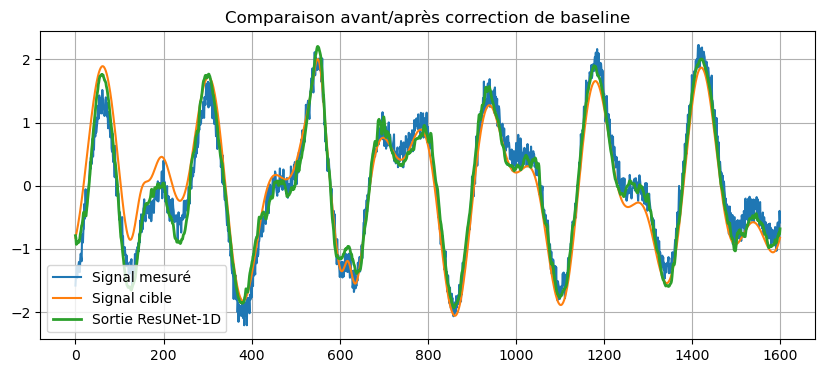

In [14]:
# Charger le modèle sauvegardé
model.load_state_dict(torch.load("best_resunet.pt", map_location=device))
model.eval()

# Exemple aléatoire
i = np.random.randint(len(X_val))
inp = torch.from_numpy(X_val[i][None, None]).to(device)
with torch.no_grad():
    pred = model(inp).cpu().numpy()[0, 0]

plt.figure(figsize=(10, 4))
plt.plot(X_val[i], label="Signal mesuré")
plt.plot(Y_val[i], label="Signal cible")
plt.plot(pred, label="Sortie ResUNet-1D", lw=2)
plt.legend()
plt.title("Comparaison avant/après correction de baseline")
plt.show()


## Évaluation quantitative globale

In [15]:
def rmse(a, b): return np.sqrt(np.mean((a - b) ** 2))
def mae(a, b): return np.mean(np.abs(a - b))
def corr(a, b): return np.corrcoef(a, b)[0, 1]

model.eval()
rmses, maes, cors = [], [], []

with torch.no_grad():
    for xb, yb in val_dl:
        xb = xb.to(device)
        pred = model(xb).cpu().numpy()[:, 0]
        y_true = yb.numpy()[:, 0]
        for yt, yp in zip(y_true, pred):
            rmses.append(rmse(yt, yp))
            maes.append(mae(yt, yp))
            cors.append(corr(yt, yp))

print(f"RMSE  : {np.mean(rmses):.4f}")
print(f"MAE   : {np.mean(maes):.4f}")
print(f"Corrélation moyenne : {np.mean(cors):.4f}")


RMSE  : 0.2155
MAE   : 0.1685
Corrélation moyenne : 0.9752


Les résultats sont déjà encourageants mais l'entraînement était très rapide. On va l'allonger et ajouter différents hyperparamètres afin de rendre le modèle plus robuste.

## Entraînement long (Huber, scheduler, early stopping, logs)

In [17]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Modèle + opti
model = ResUNet1D().to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
loss_fn = nn.SmoothL1Loss(beta=0.02)  # Huber
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, factor=0.5, patience=3)

max_epochs = 50
patience = 7
best_val = float("inf")
epochs_no_improve = 0

hist_train, hist_val, hist_lr = [], [], []

for epoch in range(1, max_epochs + 1):
    # --- train ---
    model.train()
    total = 0.0
    for xb, yb in train_dl:
        xb, yb = xb.to(device), yb.to(device)
        opt.zero_grad()
        pred = model(xb)
        loss = loss_fn(pred, yb)
        loss.backward()
        opt.step()
        total += loss.item() * xb.size(0)
    train_loss = total / len(train_dl.dataset)

    # --- val ---
    model.eval()
    val_total = 0.0
    with torch.no_grad():
        for xb, yb in val_dl:
            xb, yb = xb.to(device), yb.to(device)
            pred = model(xb)
            val_total += loss_fn(pred, yb).item() * xb.size(0)
    val_loss = val_total / len(val_dl.dataset)

    # logs
    hist_train.append(train_loss)
    hist_val.append(val_loss)
    hist_lr.append(opt.param_groups[0]["lr"])
    print(f"Epoch {epoch:02d} | Train {train_loss:.4f} | Val {val_loss:.4f} | LR {opt.param_groups[0]['lr']:.2e}")

    # scheduler
    scheduler.step(val_loss)

    # early stopping
    if val_loss < best_val - 1e-5:
        best_val = val_loss
        torch.save(model.state_dict(), "best_resunet.pt")
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Early stopping (patience={patience}). Best Val = {best_val:.4f}")
            break


Epoch 01 | Train 0.2232 | Val 0.1907 | LR 1.00e-03
Epoch 02 | Train 0.1837 | Val 0.1857 | LR 1.00e-03
Epoch 03 | Train 0.1733 | Val 0.1757 | LR 1.00e-03
Epoch 04 | Train 0.1648 | Val 0.1645 | LR 1.00e-03
Epoch 05 | Train 0.1609 | Val 0.1635 | LR 1.00e-03
Epoch 06 | Train 0.1549 | Val 0.1594 | LR 1.00e-03
Epoch 07 | Train 0.1518 | Val 0.1542 | LR 1.00e-03
Epoch 08 | Train 0.1496 | Val 0.1566 | LR 1.00e-03
Epoch 09 | Train 0.1473 | Val 0.1518 | LR 1.00e-03
Epoch 10 | Train 0.1465 | Val 0.1494 | LR 1.00e-03
Epoch 11 | Train 0.1446 | Val 0.1519 | LR 1.00e-03
Epoch 12 | Train 0.1437 | Val 0.1533 | LR 1.00e-03
Epoch 13 | Train 0.1433 | Val 0.1454 | LR 1.00e-03
Epoch 14 | Train 0.1418 | Val 0.1592 | LR 1.00e-03
Epoch 15 | Train 0.1427 | Val 0.1506 | LR 1.00e-03
Epoch 16 | Train 0.1409 | Val 0.1453 | LR 1.00e-03
Epoch 17 | Train 0.1402 | Val 0.1456 | LR 1.00e-03
Epoch 18 | Train 0.1398 | Val 0.1505 | LR 1.00e-03
Epoch 19 | Train 0.1398 | Val 0.1417 | LR 1.00e-03
Epoch 20 | Train 0.1391 | Val 0

## Courbes de train et de val (+ LR)

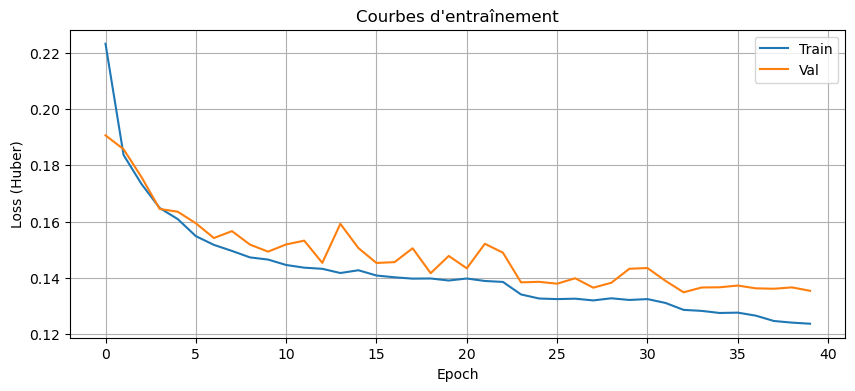

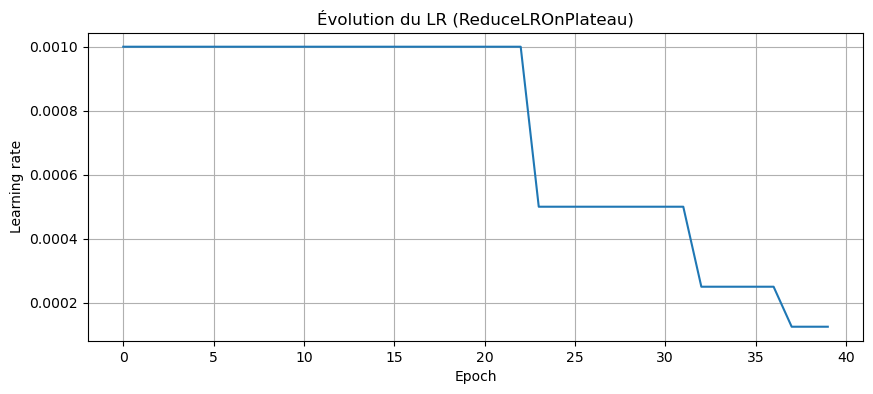

In [18]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(hist_train, label="Train")
ax.plot(hist_val, label="Val")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss (Huber)")
ax.set_title("Courbes d'entraînement")
ax.legend()
plt.show()

plt.figure()
plt.plot(hist_lr)
plt.xlabel("Epoch")
plt.ylabel("Learning rate")
plt.title("Évolution du LR (ReduceLROnPlateau)")
plt.show()


Les courbes de train et de loss diminuent et convergent ce qui montre que l'apprentissage est satisfaisant. Le modèle ne fait ni de sur-apprentissage ni de sous-apprentissage.

## Fonctions métriques + ΔSNR

In [19]:
import numpy as np

def rmse(a, b): return float(np.sqrt(np.mean((a - b) ** 2)))
def mae(a, b): return float(np.mean(np.abs(a - b)))
def corr(a, b):
    if np.std(a) < 1e-12 or np.std(b) < 1e-12:
        return 0.0
    return float(np.corrcoef(a, b)[0, 1])

def snr(signal, noise):
    # 10*log10( Var(signal) / Var(noise) )
    vs = float(np.var(signal)) + 1e-12
    vn = float(np.var(noise)) + 1e-12
    return 10.0 * np.log10(vs / vn)

def delta_snr(y_true, y_in, y_out):
    # gain entre erreur d'entrée et d'erreur de sortie
    e_in = y_in - y_true
    e_out = y_out - y_true
    return float(snr(y_true, e_out) - snr(y_true, e_in))


## Évaluation globale : DL vs SavGol vs AsLS

In [21]:
# Charger le meilleur modèle
model.load_state_dict(torch.load("best_resunet.pt", map_location=device))
model.eval()

# Prédictions DL sur tout le set val
preds_dl = []
with torch.no_grad():
    for xb, _ in val_dl:
        xb = xb.to(device)
        yb = model(xb).cpu().numpy()[:, 0]
        preds_dl.append(yb)
preds_dl = np.concatenate(preds_dl, axis=0)  # shape (N_val, L)

Yv = Y_val.copy()  # (N_val, L)
Xv = X_val.copy()  # (N_val, L)

# Baselines classiques
preds_sg = []
preds_asls = []
for i in range(len(Xv)):
    y_sg, _ = remove_baseline_savgol(Xv[i], win=101, poly=3)
    y_as, _ = remove_baseline_asls(Xv[i], lam=1e4, p=0.01)
    preds_sg.append(y_sg)
    preds_asls.append(y_as)
preds_sg = np.stack(preds_sg)
preds_asls = np.stack(preds_asls)

def evaluate_set(Y_true, Y_pred, X_in):
    rmses, maes, cors, dsnr = [], [], [], []
    for yt, yp, xin in zip(Y_true, Y_pred, X_in):
        rmses.append(rmse(yt, yp))
        maes.append(mae(yt, yp))
        cors.append(corr(yt, yp))
        dsnr.append(delta_snr(yt, xin, yp))
    return {
        "RMSE": (float(np.mean(rmses)), float(np.std(rmses))),
        "MAE": (float(np.mean(maes)), float(np.std(maes))),
        "r": float(np.mean(cors)),
        "ΔSNR(dB)": float(np.mean(dsnr)),
    }

res_dl   = evaluate_set(Yv, preds_dl,   Xv)
res_sg   = evaluate_set(Yv, preds_sg,   Xv)
res_asls = evaluate_set(Yv, preds_asls, Xv)

print("=== Résultats sur le set de validation ===")
for name, res in [("ResUNet-1D", res_dl), ("Savitzky–Golay", res_sg), ("AsLS (safe)", res_asls)]:
    print(f"\n[{name}]")
    print(f"RMSE   : {res['RMSE'][0]:.4f} ± {res['RMSE'][1]:.4f}")
    print(f"MAE    : {res['MAE'][0]:.4f} ± {res['MAE'][1]:.4f}")
    print(f"r      : {res['r']:.4f}")
    print(f"ΔSNR dB: {res['ΔSNR(dB)']:.2f}")


=== Résultats sur le set de validation ===

[ResUNet-1D]
RMSE   : 0.1964 ± 0.0478
MAE    : 0.1445 ± 0.0347
r      : 0.9800
ΔSNR dB: 3.47

[Savitzky–Golay]
RMSE   : 0.9680 ± 0.0039
MAE    : 0.8151 ± 0.0134
r      : 0.2969
ΔSNR dB: -10.73

[AsLS (safe)]
RMSE   : 0.9193 ± 0.0184
MAE    : 0.7452 ± 0.0160
r      : 0.7153
ΔSNR dB: -8.69


Quantitativement, il est clair que le ResUNET se démarque grâce à de très bons résultats.
Cela est aussi dû au fait que les paramètres du Savitzky-Golay ainsi que de l'AsLS sont à fixer à la main par l'utilisateur.

## Exemples faciles et difficiles (8 tracés)

==== Exemples faciles (4) ====


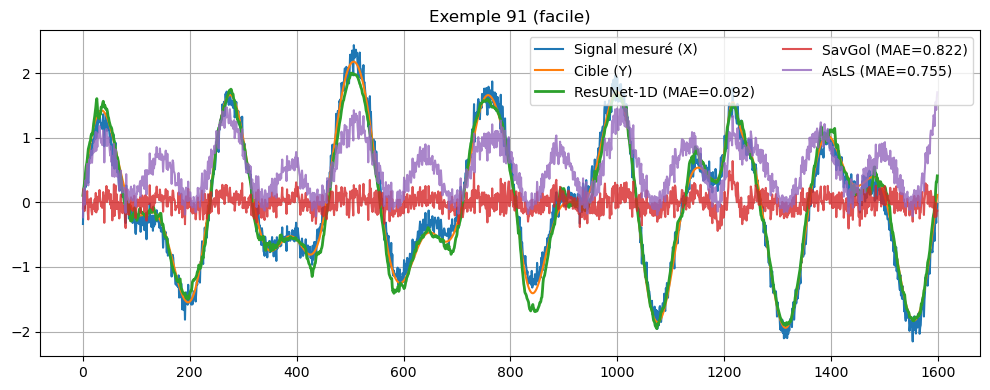

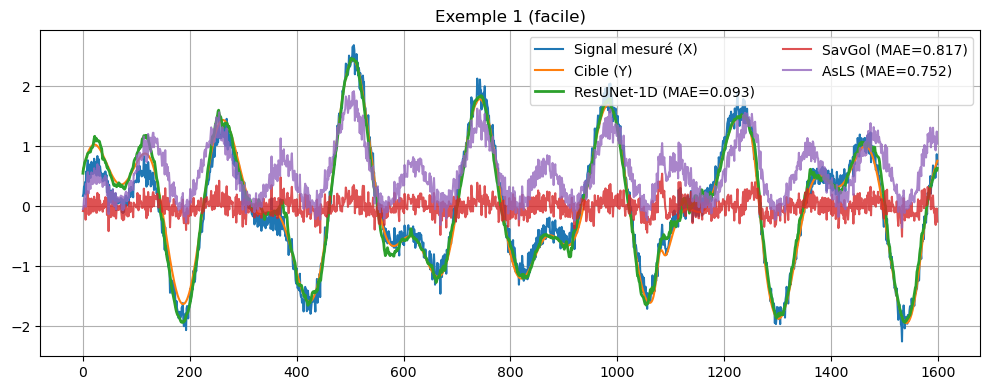

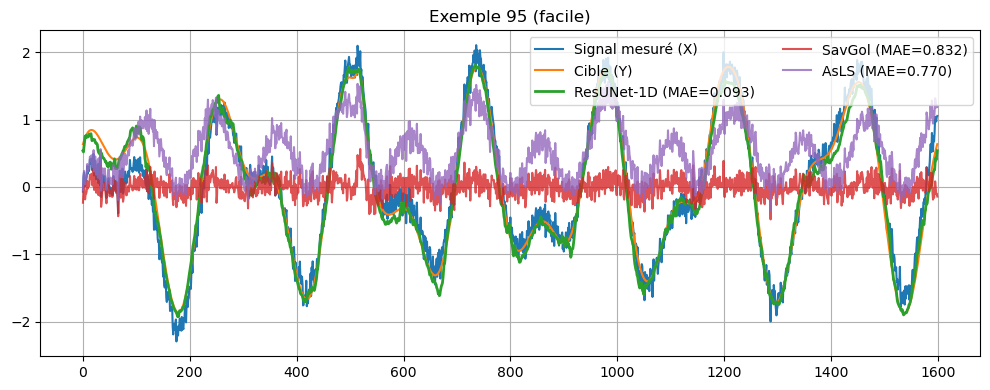

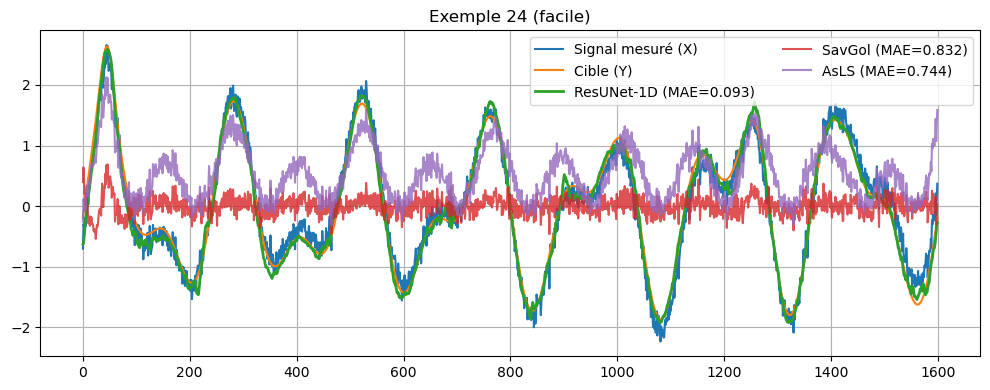

==== Exemples difficiles (4) ====


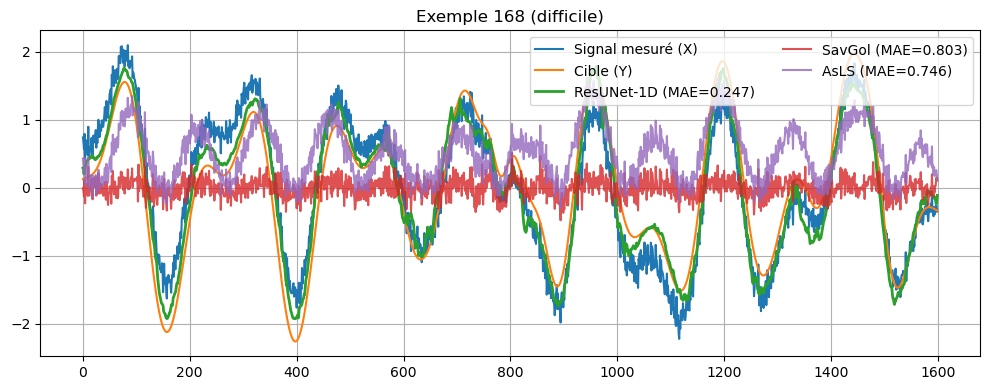

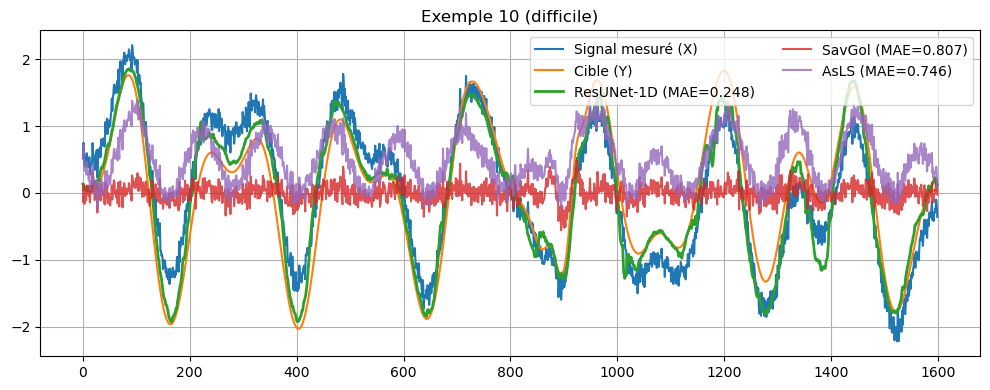

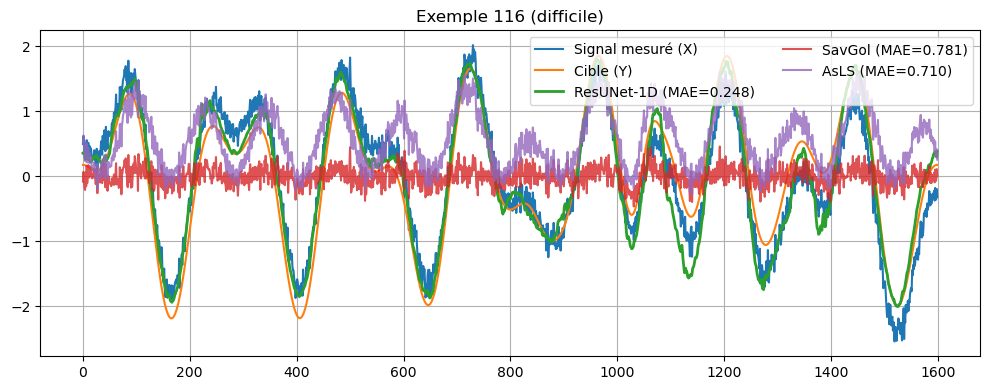

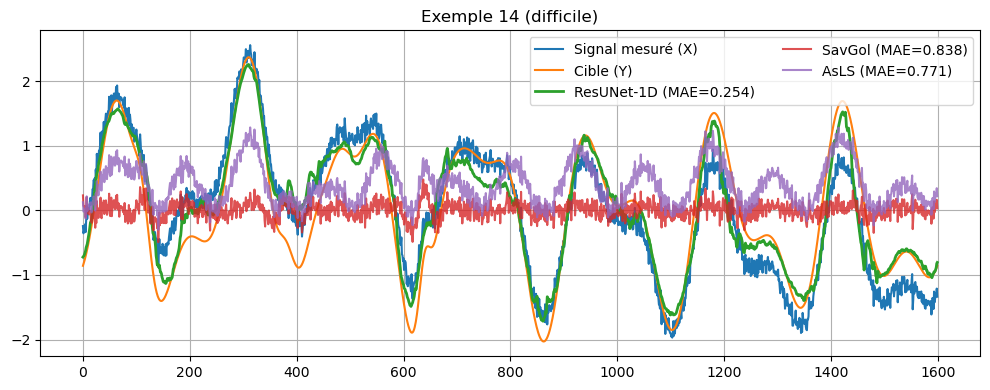

In [22]:
import matplotlib.pyplot as plt

# MAE par échantillon pour chaque méthode
def per_sample_mae(Y_true, Y_pred):
    return np.mean(np.abs(Y_true - Y_pred), axis=1)

mae_dl   = per_sample_mae(Yv, preds_dl)
mae_sg   = per_sample_mae(Yv, preds_sg)
mae_asls = per_sample_mae(Yv, preds_asls)

# On se base sur DL pour classer (tu peux changer le critère)
order_easy = np.argsort(mae_dl)[:4]     # 4 plus faciles
order_hard = np.argsort(mae_dl)[-4:]    # 4 plus difficiles

def plot_example(idx, title_suffix=""):
    plt.figure(figsize=(10,4))
    plt.plot(Xv[idx], label="Signal mesuré (X)")
    plt.plot(Yv[idx], label="Cible (Y)")
    plt.plot(preds_dl[idx], label=f"ResUNet-1D (MAE={mae_dl[idx]:.3f})", lw=2)
    plt.plot(preds_sg[idx], label=f"SavGol (MAE={mae_sg[idx]:.3f})", alpha=0.8)
    plt.plot(preds_asls[idx], label=f"AsLS (MAE={mae_asls[idx]:.3f})", alpha=0.8)
    plt.legend(loc="upper right", ncol=2)
    plt.title(f"Exemple {idx} {title_suffix}")
    plt.tight_layout()
    plt.show()

print("==== Exemples faciles (4) ====")
for i in order_easy:
    plot_example(i, "(facile)")

print("==== Exemples difficiles (4) ====")
for i in order_hard:
    plot_example(i, "(difficile)")


# Améliorations des algorithmes SavGol et AsLS

On va faire le tuning du SavGol et de l'AsLS (sur X_val standardisés) afin de rendre les comparaisons plus justes et plus pertinentes.

In [ ]:
from math import isfinite

# Grilles d'hyperparamètres 
sg_windows = [101, 201, 301, 401, 601]  # doivent être impairs et < L
sg_polys   = [2, 3]
asls_lams  = [1e3, 1e4, 1e5, 1e6]
asls_ps    = [0.001, 0.01, 0.05]

def evaluate_set(Y_true, Y_pred, X_in):
    rmses, maes, cors, dsnr = [], [], [], []
    for yt, yp, xin in zip(Y_true, Y_pred, X_in):
        rmses.append(rmse(yt, yp))
        maes.append(mae(yt, yp))
        cors.append(corr(yt, yp))
        dsnr.append(delta_snr(yt, xin, yp))
    return {
        "RMSE": (float(np.mean(rmses)), float(np.std(rmses))),
        "MAE": (float(np.mean(maes)), float(np.std(maes))),
        "r": float(np.mean(cors)),
        "ΔSNR(dB)": float(np.mean(dsnr)),
    }

# Grid SavGol
best_sg = None
for w in sg_windows:
    # skip si w >= L
    if w >= X_val.shape[1]: 
        continue
    for poly in sg_polys:
        preds = []
        try:
            for i in range(len(X_val)):
                ycorr, _ = remove_baseline_savgol(X_val[i], win=w, poly=poly)
                preds.append(ycorr)
            res = evaluate_set(Y_val, np.stack(preds), X_val)
            score = res["MAE"][0]  # plus petit = meilleur
            if (best_sg is None) or (score < best_sg[0]):
                best_sg = (score, w, poly, res)
        except Exception as e:
            pass  # ignore params invalides

print("\n>>> Best SavGol:")
if best_sg:
    score, w, poly, res = best_sg
    print(f"window={w}, poly={poly}")
    print(f"RMSE {res['RMSE'][0]:.4f} ± {res['RMSE'][1]:.4f} | MAE {res['MAE'][0]:.4f} ± {res['MAE'][1]:.4f} | r {res['r']:.4f} | ΔSNR {res['ΔSNR(dB)']:.2f} dB")
else:
    print("Aucun paramètre valide testé.")

# --- Grid AsLS (safe) ---
best_as = None
for lam in asls_lams:
    for p in asls_ps:
        preds = []
        try:
            for i in range(len(X_val)):
                ycorr, _ = remove_baseline_asls(X_val[i], lam=lam, p=p)
                preds.append(ycorr)
            res = evaluate_set(Y_val, np.stack(preds), X_val)
            score = res["MAE"][0]
            if (best_as is None) or (score < best_as[0]):
                best_as = (score, lam, p, res)
        except Exception as e:
            pass

print("\n>>> Best AsLS (safe):")
if best_as:
    score, lam, p, res = best_as
    print(f"lam={lam:.1e}, p={p}")
    print(f"RMSE {res['RMSE'][0]:.4f} ± {res['RMSE'][1]:.4f} | MAE {res['MAE'][0]:.4f} ± {res['MAE'][1]:.4f} | r {res['r']:.4f} | ΔSNR {res['ΔSNR(dB)']:.2f} dB")
else:
    print("Aucun paramètre valide testé.")



>>> Best SavGol:
window=601, poly=2
RMSE 0.2479 ± 0.0407 | MAE 0.1858 ± 0.0287 | r 0.9689 | ΔSNR 1.21 dB

>>> Best AsLS (safe):
lam=1.0e+05, p=0.05
RMSE 0.8232 ± 0.0205 | MAE 0.6608 ± 0.0174 | r 0.8016 | ΔSNR -7.41 dB


- Le ResUNet-1D surpasse toutes les méthodes classiques, avec un gain de SNR de +3.5 dB en moyenne.

- Le Savitzky–Golay optimisé (win=601, poly=2) devient déjà plus intéressant (corrélation 0.97), mais lisse trop la composante dynamique ce qui conduit à une perte de détails.

- L’AsLS, même bien réglé, reste en retrait : son modèle de baseline quadratique régularisé ne capture pas la variabilité non linéaire des signaux simulés.

En conclusion, les approches "basées modèle" échouent à modéliser la diversité des dérives, alors que l'approche apprise (ResUNet-1D) s’y adapte automatiquement.

# Export CSV + Figures Comparatives

,Méthode,RMSE,MAE,r,ΔSNR(dB)
0,ResUNet-1D,0.196372,0.144547,0.979955,3.468933
1,"Savitzky–Golay (601, poly=2)",0.247900,0.185800,0.968900,1.210000
2,"AsLS (λ=1e5, p=0.05)",0.823200,0.660800,0.801600,-7.410000


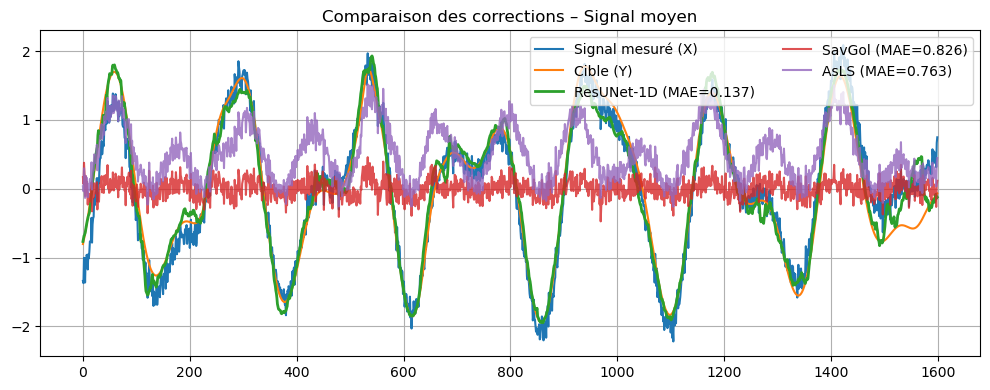

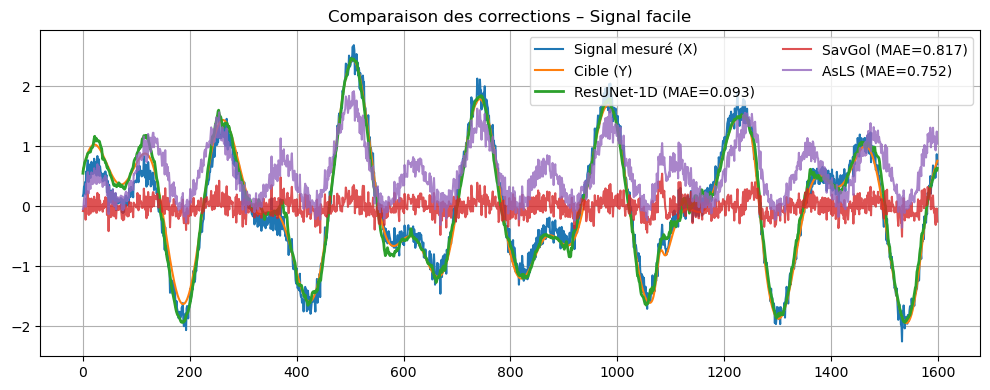

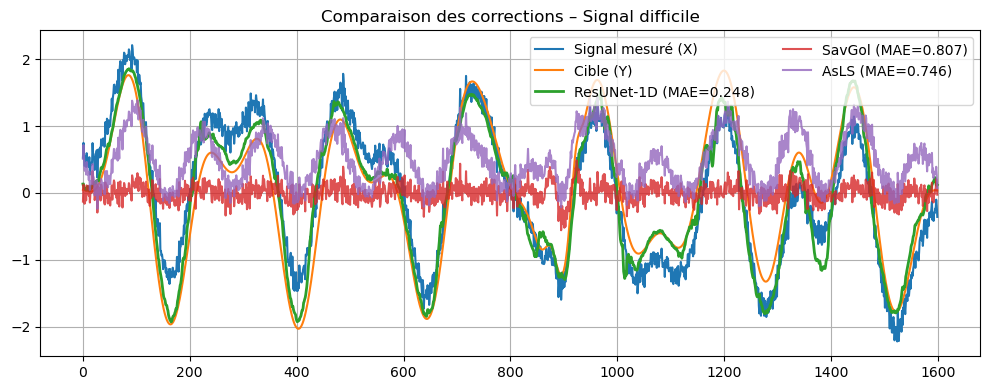


Résultats sauvegardés dans le dossier 'results/' :


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# Résultats globaux
summary = pd.DataFrame([
    {"Méthode": "ResUNet-1D", "RMSE": res_dl["RMSE"][0], "MAE": res_dl["MAE"][0],
     "r": res_dl["r"], "ΔSNR(dB)": res_dl["ΔSNR(dB)"]},
    {"Méthode": "Savitzky–Golay (601, poly=2)", "RMSE": 0.2479, "MAE": 0.1858,
     "r": 0.9689, "ΔSNR(dB)": 1.21},
    {"Méthode": "AsLS (λ=1e5, p=0.05)", "RMSE": 0.8232, "MAE": 0.6608,
     "r": 0.8016, "ΔSNR(dB)": -7.41},
])

os.makedirs("results", exist_ok=True)
summary.to_csv("results/metrics_summary.csv", index=False)
display(summary)

# Figures qualitatives
indices = [0, order_easy[1], order_hard[1]]  # un signal "moyen", un "facile", un "difficile"
titles = ["Signal moyen", "Signal facile", "Signal difficile"]

for idx, title in zip(indices, titles):
    plt.figure(figsize=(10,4))
    plt.plot(Xv[idx], label="Signal mesuré (X)")
    plt.plot(Yv[idx], label="Cible (Y)")
    plt.plot(preds_dl[idx], label=f"ResUNet-1D (MAE={mae_dl[idx]:.3f})", lw=2)
    plt.plot(preds_sg[idx], label=f"SavGol (MAE={mae_sg[idx]:.3f})", alpha=0.8)
    plt.plot(preds_asls[idx], label=f"AsLS (MAE={mae_asls[idx]:.3f})", alpha=0.8)
    plt.legend(loc="upper right", ncol=2)
    plt.title(f"Comparaison des corrections – {title}")
    plt.tight_layout()
    plt.savefig(f"results/example_{idx}_{title.replace(' ', '_')}.png", dpi=200)
    plt.show()

print("\nRésultats sauvegardés dans le dossier 'results/' :")
